In [1]:
# In[1]:


import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw
import popsims
from gala.units import UnitSystem
import pandas as pd
from scipy.interpolate import interp1d, griddata, InterpolatedUnivariateSpline
from astropy.io.votable import parse_single_table
import numba
plot_style()
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm import tqdm
#get_ipython().run_line_magic('matplotlib', 'inline')


# In[2]:
from popsims.plot_style import plot_style
plot_style()


path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'

In [2]:
class M31Halo(GalacticComponent):
    """
    power-law stellar density for M31's halo by Ibata et al. 2014
    
    """
    def __init__(self, q=1.11, gamma=-3):
        super().__init__({'q': q, 'gamma': gamma})

    def stellar_density(self, r, z):
        """
        Compute the stellar density at a particular position

        Args:
        ----
            x, y, z: galacto-centric x, y,z ( astropy.quantity )
        Returns:
        -------
            unit-less stellar density

        Examples:
        --------
            > d = Disk.stellar_density(100*u.pc, -100*u.pc)
        """
        #add a raise error if r <0
        
        s= (r**2+(z/self.q)**2)**0.5

        return s**self.gamma

In [3]:
nsample=1e4
d_M31=770*u.kpc
model=M31Halo()
ds=np.concatenate([model.sample_distances(0.1, 200_000, 1000,  dsteps=1000) for x in range(0, 100)])
ds=np.random.choice(ds, int(nsample))

eta= 2*np.pi*np.random.uniform(0, 1, len(ds))
xi= np.arccos(2*np.random.uniform(0, 1, len(ds))-1)-np.pi/2
r, z= popsims.galaxy.transform_tocylindrical(eta, xi, ds)

#get x, y as xl cos b or something
#add the center for M31
distances_to_use=d_M31.to(u.pc).value+z

mw_model=Disk(L=2600, H=350)+0.12*Disk(L=3600, H=900)+0.0025*Halo()
    
ds=np.concatenate([mw_model.sample_distances(0.1, 200_000, 1000,  dsteps=1000) for x in range(0, 100)])
l= 2*np.pi*np.random.uniform(0, 1, len(ds))
b= np.arccos(2*np.random.uniform(0, 1, len(ds))-1)-np.pi/2
rm, zm= popsims.galaxy.transform_tocylindrical(l, b, ds)


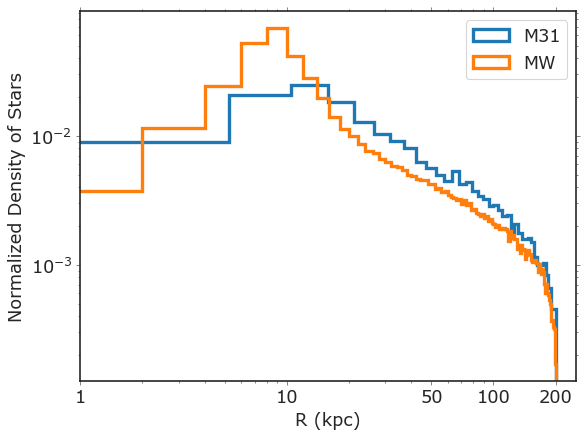

In [4]:
fig, ax=plt.subplots()
_= plt.hist( np.abs(r/1000),  bins='auto', histtype='step', 
            density=True, log=True, label='M31', linewidth=3, range=[0,200])
_= plt.hist( np.abs(rm/1000), bins=100,  histtype='step',\
            density=True, log=True, label='MW',  linewidth=3,  range=[0,200])
plt.legend()
ax.minorticks_on()
ax.set(ylabel='Normalized Density of Stars', xlabel=r'R (kpc)', xscale='log', xticks=[1, 10, 50, 100,  200],
      xticklabels=[1, 10, 50, 100,  200])
plt.savefig('../figures/simulated_densities.jpeg')

In [18]:
rgc='10_20'
fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
df=pd.read_csv(fname)

#put to the desired distance modulus 
mw_df= df.query("galaxy == 'MW'").reset_index(drop=True)
m31_df= df.query("galaxy =='M31'").reset_index(drop=True)

[Text(0.5, 0, 'R062-Z087'), Text(0, 0.5, 'Z087')]

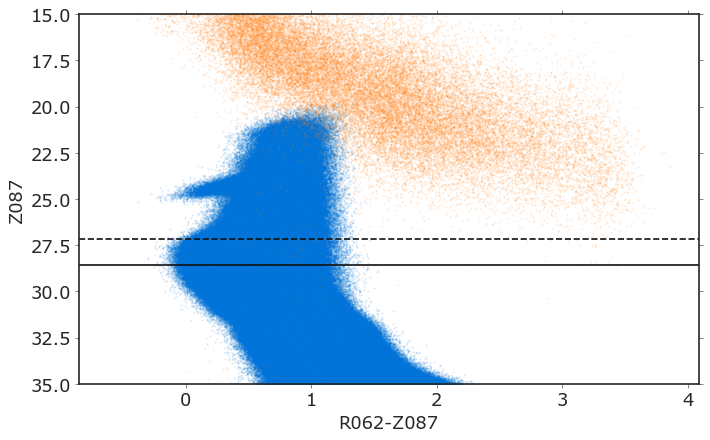

In [19]:
fig, ax=plt.subplots(figsize=(10, 6))

#ax.set(title='M31')
#ax.set(title='Milky Way')
p=ax.scatter(m31_df.appF062mag-m31_df.appF087mag, m31_df.appF087mag, s=1, alpha=0.1, c='#0074D9', label='M31 Halo')
ax.invert_yaxis()
ax.set(ylim=[35, 15])


ax.scatter(mw_df.appF062mag-mw_df.appF087mag, mw_df.appF087mag, s=1, alpha=0.1, c='#FF851B', label='Milky Way')
#ax.invert_yaxis()
#ax[1].set(ylim=[35, 15])

#for a in ax:
ax.axhline(28.59, linestyle='-', c='#111111')
ax.axhline(27.15, linestyle='--', c='#111111')
ax.set(xlabel= 'R062-Z087', ylabel='Z087')

#plt.tight_layout()
#cax = fig.add_axes([0.08, 0., .3, 0.04])
#plt.colorbar(p, ax=ax, cax=cax, orientation='horizontal')
#cax.set(xlabel=r'[M/H]')


In [39]:
#check luminosity functions 
rgc='10_20'
fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
df=pd.read_csv(fname)

from astropy.io.votable import parse_single_table
path_pandas= '/users/caganze/research/stellarstreams/data/pandas/'
data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()

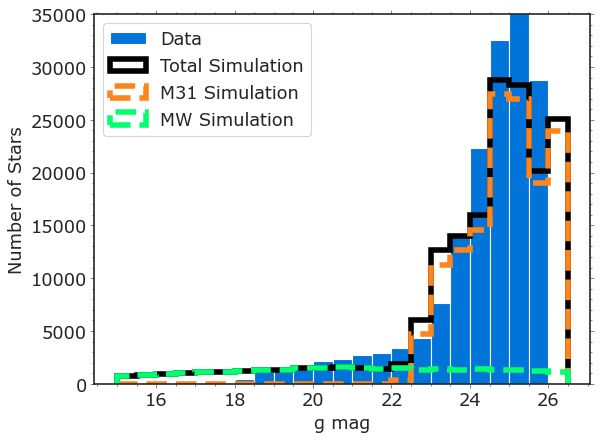

In [43]:
fig, ax=plt.subplots()
_= plt.hist(data.g, bins= np.arange(15, 27, 0.5), log=False, label='Data', color='#0074D9')
_= plt.hist(df.appgmag.values,
            bins= np.arange(15, 27, 0.5), log=False, histtype='step', linewidth=5, \
            label='Total Simulation', linestyle='-', color='k')
_= plt.hist(df.appgmag[df.galaxy.values == 'M31'].values,
            bins= np.arange(15, 27, 0.5), log=False, histtype='step',\
            linestyle='--', linewidth=5, label='M31 Simulation', color='#FF851B')

_= plt.hist(df.appgmag[df.galaxy.values == 'MW'].values,
            bins= np.arange(15, 27, 0.5), log=False, histtype='step', linewidth=5, \
            label='MW Simulation', linestyle='--', color='#01FF70')



ax.set(xlabel='g mag', ylabel='Number of Stars', ylim=[0, 35_000])
ax.minorticks_on()
plt.legend()
plt.savefig('../figures/lf_check_rgc{}.pdf'.format(rgc))

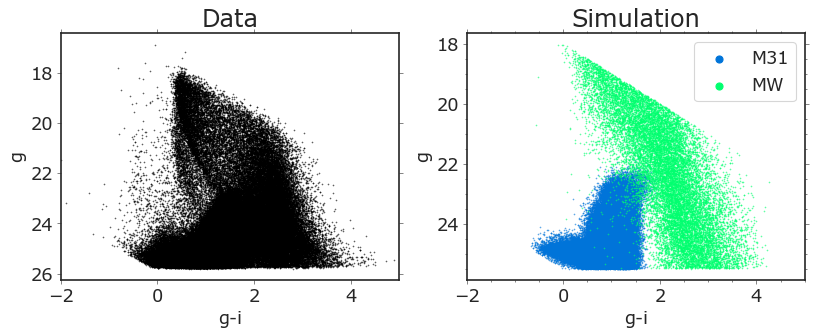

In [44]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
ax[0].scatter(data.g-data.i, data.g, c='k', s=.1)
df0= df[np.logical_and.reduce([df.appgmag.values <25.5, \
                       df.appgmag.values >18,\
                        df.appimag.values >18.,\
                       df.appimag.values < 25.5,
                       (df.galaxy.values == 'M31')]) ]

df1= df[np.logical_and.reduce([df.appgmag.values <25.5, \
                       df.appgmag.values >18,\
                        df.appimag.values >18.,\
                       df.appimag.values < 25.5,
                       (df.galaxy.values == 'MW')]) ]
ax[1].scatter(df0.appgmag-df0.appimag, df0.appgmag, s=.1, label='M31',  color='#0074D9')
ax[1].scatter(df1.appgmag-df1.appimag, df1.appgmag, s=.1, label='MW', color='#01FF70')


for a in ax:
    a.invert_yaxis()
    a.set(xlabel='g-i', ylabel='g', xlim=[-2, 5])
ax[-1].legend()
ax[-1].legend(markerscale=20)
ax[-1].minorticks_on()
ax[0].set(title='Data')
ax[1].set(title='Simulation')
plt.savefig('../figures/simulated_CMD_CFHT_rgc{}.jpeg'.format(rgc))

In [45]:
len(df[df.F087mag.between(18, 28.69)])/2.8

51365.357142857145